In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model


In [3]:
# Load and preprocess data
data = pd.read_csv('SPY.csv', parse_dates=True, index_col='Date')  # Ensure 'Date' is parsed and set as index
print(data.head())

                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2010-01-04  112.370003  113.389999  111.510002  113.330002  86.860069   
2010-01-05  113.260002  113.680000  112.849998  113.629997  87.090027   
2010-01-06  113.519997  113.989998  113.430000  113.709999  87.151321   
2010-01-07  113.500000  114.330002  113.180000  114.190002  87.519203   
2010-01-08  113.889999  114.620003  113.660004  114.570000  87.810455   

               Volume  
Date                   
2010-01-04  118944600  
2010-01-05  111579900  
2010-01-06  116074400  
2010-01-07  131091100  
2010-01-08  126402800  


In [4]:
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)  # Remove any NaN values that arise from shifting


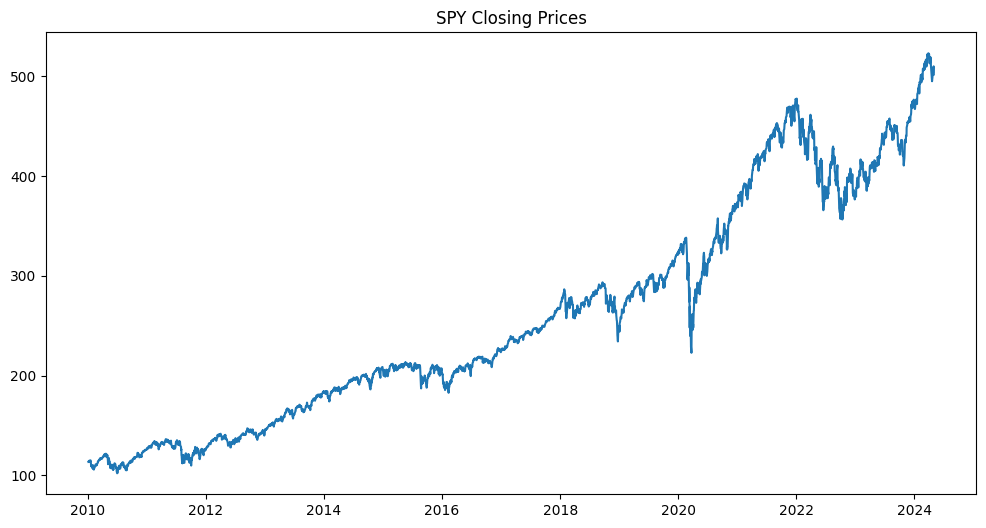

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('SPY Closing Prices')
plt.show()


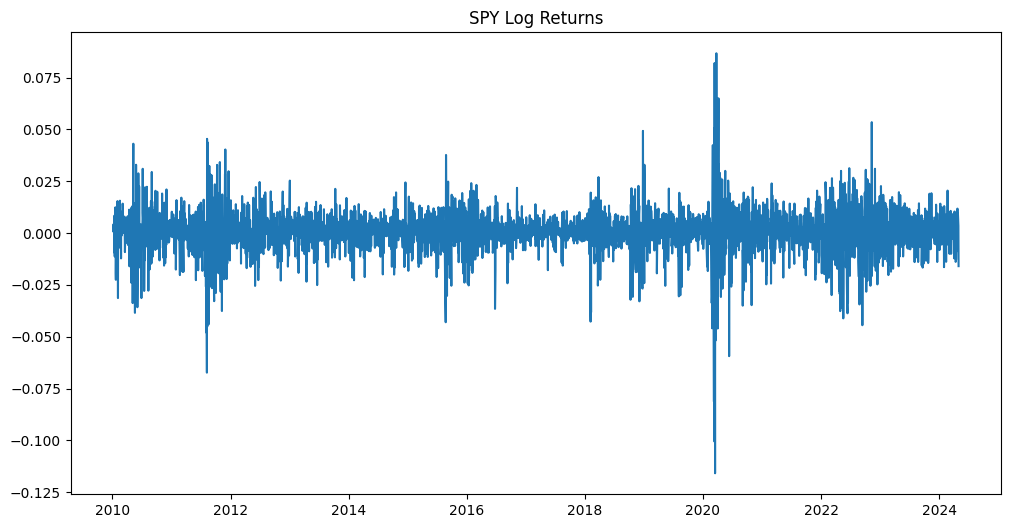

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(data['Log_Returns'])
plt.title('SPY Log Returns')
plt.show()


In [7]:
# Create training and testing sets
train = data['2010':'2019'].copy()
test = data['2020':].copy()



In [103]:
# Rescale log returns for the training and testing data
train['Rescaled_Log_Returns'] = 100 * train['Log_Returns']
test['Rescaled_Log_Returns'] = 100 * test['Log_Returns']


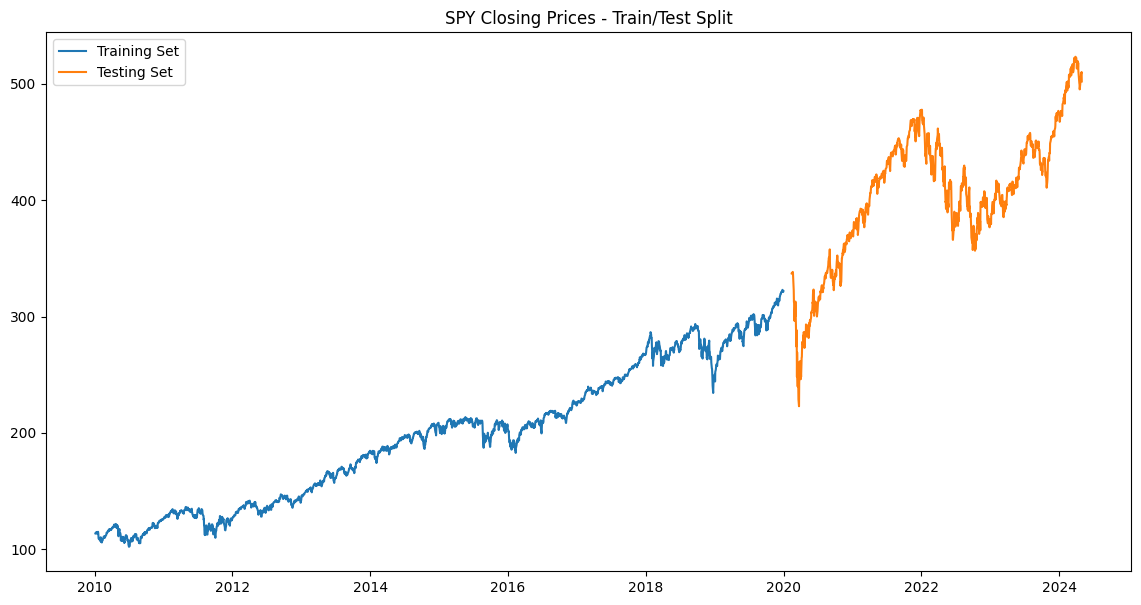

In [97]:
# Plot the closing prices to visualize the train and test split
plt.figure(figsize=(14, 7))
plt.plot(train['Close'], label='Training Set')
plt.plot(test['Close'], label='Testing Set')
plt.title('SPY Closing Prices - Train/Test Split')
plt.legend()
plt.show()

In [98]:
# Fit a GARCH(1, 1) model to the rescaled log returns
garch_model = arch_model(train['Rescaled_Log_Returns'], vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')
print(garch_result.summary())

                      Constant Mean - GARCH Model Results                       
Dep. Variable:     Rescaled_Log_Returns   R-squared:                       0.000
Mean Model:               Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GARCH   Log-Likelihood:               -3002.21
Distribution:                    Normal   AIC:                           6012.43
Method:              Maximum Likelihood   BIC:                           6035.75
                                          No. Observations:                 2515
Date:                  Fri, May 10 2024   Df Residuals:                     2514
Time:                          18:12:42   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0788  1.387e-02      5.680  1

In [104]:

egarch_model = arch_model(train['Rescaled_Log_Returns'], vol='EGARCH', p=1, q=1)
egarch_result = egarch_model.fit(disp='off')
print(egarch_result.summary())


                      Constant Mean - EGARCH Model Results                      
Dep. Variable:     Rescaled_Log_Returns   R-squared:                       0.000
Mean Model:               Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       EGARCH   Log-Likelihood:               -3009.73
Distribution:                    Normal   AIC:                           6027.47
Method:              Maximum Likelihood   BIC:                           6050.79
                                          No. Observations:                 2515
Date:                  Fri, May 10 2024   Df Residuals:                     2514
Time:                          18:13:54   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0934  1.701e-03     54.

In [92]:
print("Last date in training data:", train.index[-1])


Last date in training data: 2019-12-31 00:00:00


In [93]:
print("First date in testing data:", test.index[0])


First date in testing data: 2020-02-13 00:00:00


In [111]:
# Forecasting future volatility from the first available date in 2020
forecast_horizon = len(test)
forecasts = garch_result.forecast(horizon=forecast_horizon, start=len(train)-1)
# Checking the forecast output
if forecasts.variance is not None:
    forecasted_variance = forecasts.variance.dropna(how='all')
    if not forecasted_variance.empty:
        # Calculate the square root of the last forecasted variance to get the volatility
        forecasted_volatility = np.sqrt(forecasted_variance.iloc[0]) * np.sqrt(252)     # Annualize with sqrt(252)
        forecasted_volatility.index = pd.date_range(start=test.index[0], periods=len(forecasted_volatility), freq='B')
        print("Forecasted Volatility:")
        print(forecasted_volatility)
    else:
        print("Forecasted variance data is empty.")
else:
    print("No variance data in forecast.")

Forecasted Volatility:
2020-02-13     8.301778
2020-02-14     8.678785
2020-02-17     9.026880
2020-02-18     9.349768
2020-02-19     9.650424
                ...    
2024-02-29    15.515507
2024-03-01    15.515507
2024-03-04    15.515507
2024-03-05    15.515507
2024-03-06    15.515507
Freq: B, Name: 2019-12-31 00:00:00, Length: 1060, dtype: float64


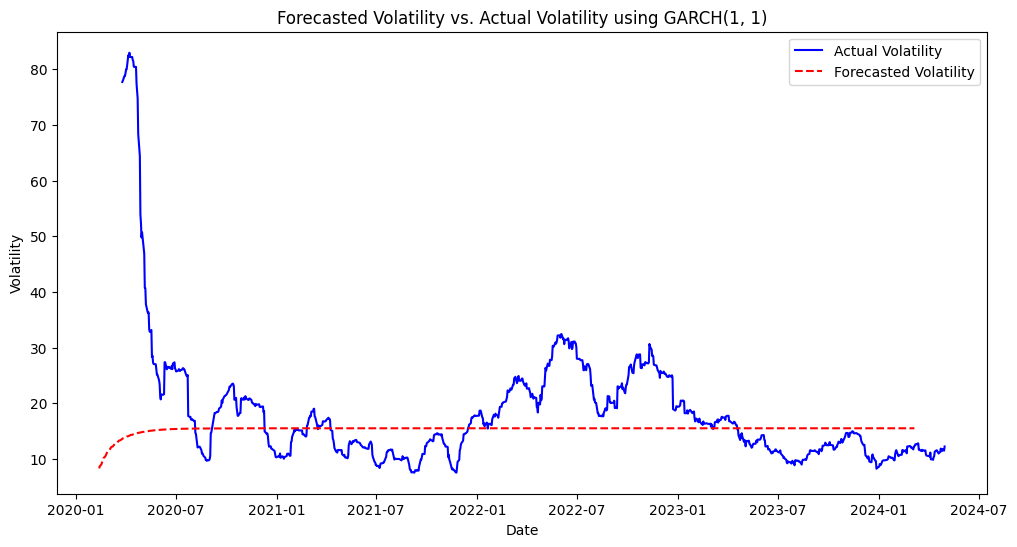

In [116]:

plt.figure(figsize=(12, 6))

plt.plot(test.index, test['Actual_Volatility'], label='Actual Volatility', color='blue')


plt.plot(forecasted_volatility.index, forecasted_volatility,
         label='Forecasted Volatility', linestyle='--', color='red')

plt.title('Forecasted Volatility vs. Actual Volatility using GARCH(1, 1)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

plt.show()